In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_3d_response_pf_ratio_surface(
    run_folder: str,
    fold: int,
    test_csv: str,
    sample_index: int,
    fluid_range: tuple[float,float],
    pf_ratio_range: tuple[float,float],
    n_fluid: int = 50,
    n_ratio: int = 50
):
    """
    Draws one static 3D surface per fluid type, in (Fluid, Propellant/Fluid) space:
      X = Total.Fluid,
      Y = Propellant/Fluid ratio,
      Z = predicted Output1,
    marking the actual sample point.
    """
    # ─── Column names ─────────────────────────────────────────────────────────
    gpi_col           = "GPI (gross perforated interval ft)"
    prop_per_gpi_col  = "Proppant.per.GPI..lb.ft."
    fluid_per_gpi_col = "Fluid.per.GPI..gal.ft."
    total_prop_col    = "Total.Proppant.Volume"
    total_fluid_col   = "Total.Fluid"
    fluid_type_col    = "Fluid.Type"
    output1_col       = "BOE_Prodoction_2 year cum"

    # ─── Load hyperparams & norms ─────────────────────────────────────────────
    run_id = os.path.basename(os.path.normpath(run_folder))
    with open(os.path.join(run_folder, f"{run_id}_hyperparams.json")) as f:
        hp = json.load(f)
    with open(os.path.join(run_folder, f"{run_id}_norms.json")) as f:
        norms = json.load(f)

    layer_dims = hp["layer_dims"]
    activations = hp["activations"]
    include_ratio_features = hp.get("include_ratio_features", True)

    # norms.json: scalar y1_mean, y1_std for output1
    y1_mean = float(norms["y_mean"])
    y1_std  = float(norms["y_std"])
    x_mean = norms["x_mean"]
    x_std  = norms["x_std"]

    # ─── Load test data & pick sample ────────────────────────────────────────
    df = pd.read_csv(test_csv)
    sample = df.iloc[sample_index]
    gpi = float(sample[gpi_col])
    sf  = float(sample[total_fluid_col])
    sp  = float(sample[total_prop_col])
    st  = sample[fluid_type_col]
    y1_true = float(sample[output1_col])
    sample_ratio = sp/sf

    # ─── Feature lists ────────────────────────────────────────────────────────
    numeric_feats = list(x_mean.keys())
    if not include_ratio_features:
        numeric_feats = [c for c in numeric_feats
                         if c not in (prop_per_gpi_col, fluid_per_gpi_col)]
    fluid_types = sorted(df[fluid_type_col].unique())
    dummy_feats = [f"{fluid_type_col}_{ft}" for ft in fluid_types]

    # ─── Define & load network ────────────────────────────────────────────────
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i,h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = len(numeric_feats) + len(dummy_feats),
        hidden_dims = layer_dims,
        activations = activations,
        out_dim     = 2
    ).to(device)
    model.load_state_dict(torch.load(
        os.path.join(run_folder, f"{run_id}_fold{fold}.pth"),
        map_location=device
    ))
    model.eval()

    # ─── Build grid in (fluid, ratio) ────────────────────────────────────────
    fluid_vals = np.linspace(fluid_range[0], fluid_range[1], n_fluid)
    ratio_vals = np.linspace(pf_ratio_range[0], pf_ratio_range[1], n_ratio)
    Fg, Rg = np.meshgrid(fluid_vals, ratio_vals)  # shapes (n_ratio, n_fluid)

    # ─── Baseline feature dict ───────────────────────────────────────────────
    base = {f: float(sample[f]) for f in numeric_feats}
    for d in dummy_feats:
        base[d] = 0.0

    # ─── Loop per fluid type ──────────────────────────────────────────────────
    for ft in fluid_types:
        # set one-hot
        for dft in dummy_feats:
            base[dft] = 1.0 if dft==f"{fluid_type_col}_{ft}" else 0.0

        Z = np.zeros_like(Fg)
        for i in range(n_ratio):
            for j in range(n_fluid):
                f = fluid_vals[j]
                r = ratio_vals[i]
                p = f * r
                # assign swept inputs
                base[total_fluid_col] = f
                base[total_prop_col]  = p
                if include_ratio_features:
                    base[prop_per_gpi_col]  = p  / gpi
                    base[fluid_per_gpi_col] = f  / gpi
                # normalize & assemble
                x_vec = [(base[c]-x_mean[c])/x_std[c] for c in numeric_feats]
                x_vec += [base[d] for d in dummy_feats]
                X_in = torch.tensor([x_vec], dtype=torch.float32).to(device)
                with torch.no_grad():
                    out = model(X_in).cpu().numpy().flatten()
                Z[i,j] = float(out[0] * y1_std + y1_mean)

        # ─── Plot 3D surface ────────────────────────────────────────────────
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(Fg, Rg, Z, cmap='viridis', edgecolor='none')
        # mark actual sample point in (sf, sample_ratio, y1_true)
        ax.scatter(sf, sample_ratio, y1_true, color='red', s=50, label='Actual point')
        ax.legend()
        ax.set_title(f"{output1_col} vs Fluid & (Prop/F)  [type={ft}]")
        ax.set_xlabel("Total Fluid")
        ax.set_ylabel("Propellant/Fluid Ratio")
        ax.set_zlabel(output1_col)
        plt.tight_layout()
        plt.show()




In [ ]:
sample_index=1

# relu

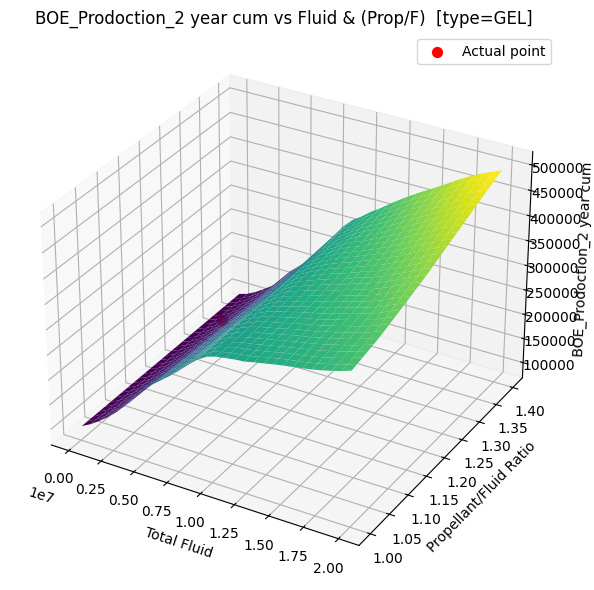

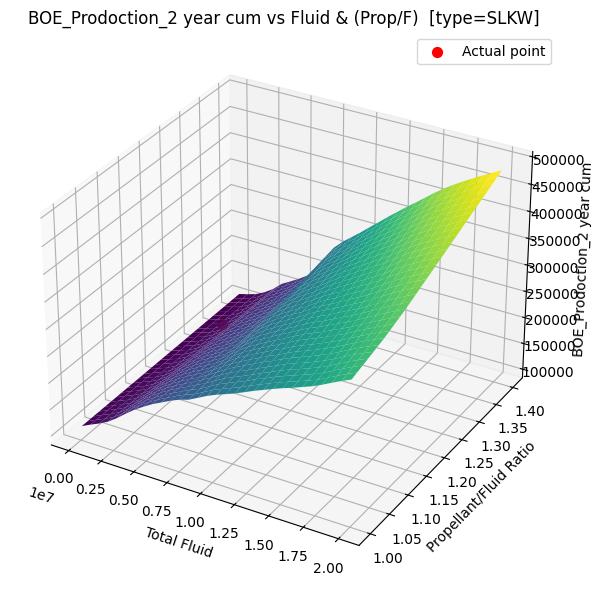

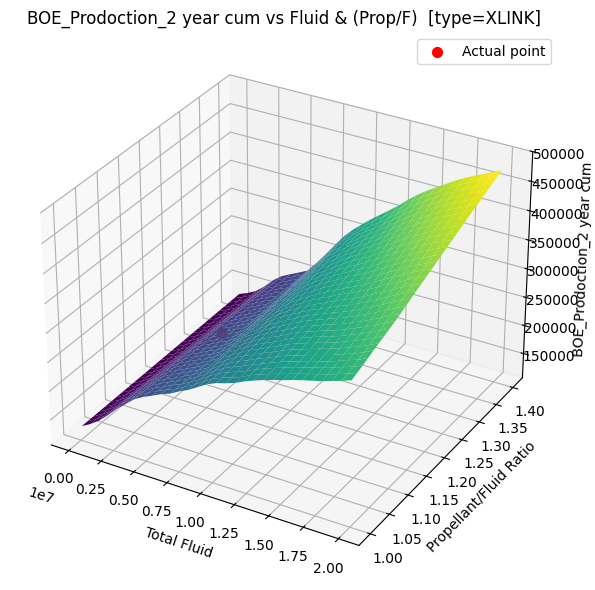

In [3]:

# ─── Example usage ─────────────────────────────────────────────────────────
plot_3d_response_pf_ratio_surface(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/d3feed88",
    fold=1,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    fluid_range=(1e5, 2e7),
    pf_ratio_range=(1, 1.4),
    n_fluid=30,
    n_ratio=30
)

# softplus

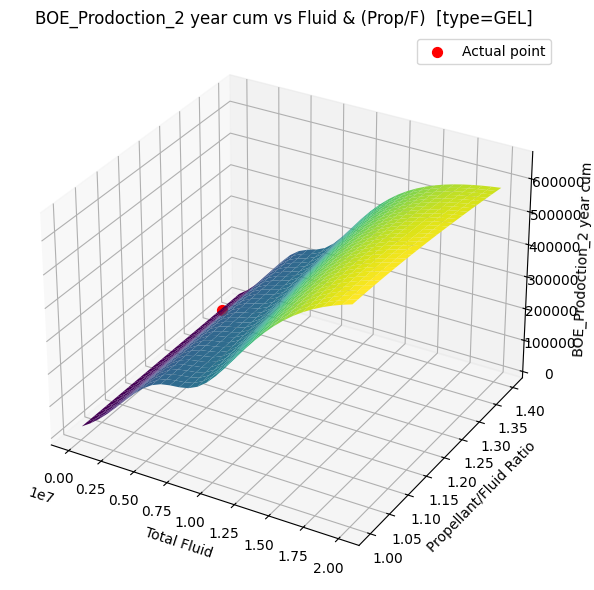

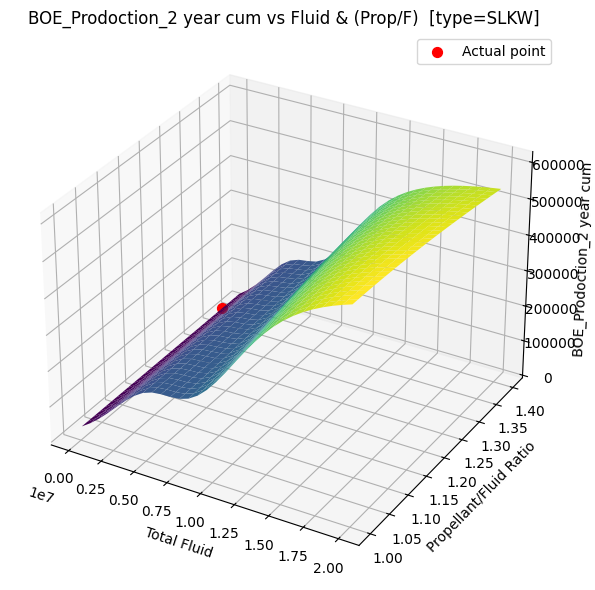

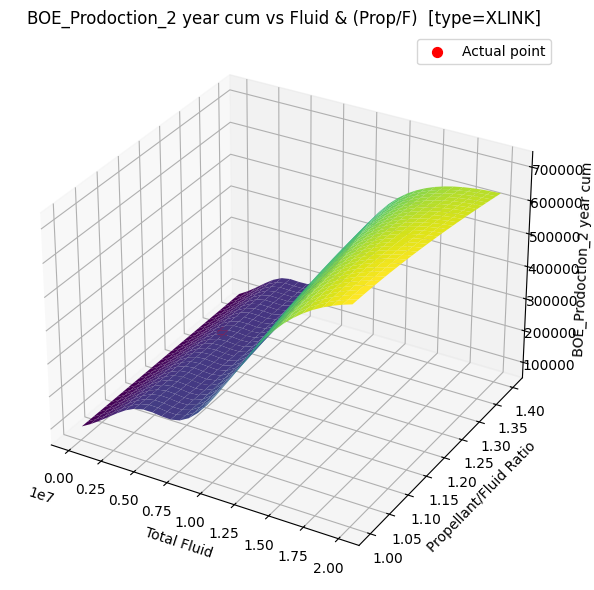

In [4]:

# ─── Example usage ─────────────────────────────────────────────────────────
plot_3d_response_pf_ratio_surface(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/4eb5e823",
    fold=1,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    fluid_range=(1e5, 2e7),
    pf_ratio_range=(1, 1.4),
    n_fluid=30,
    n_ratio=30
)

# relu rdundatn removed

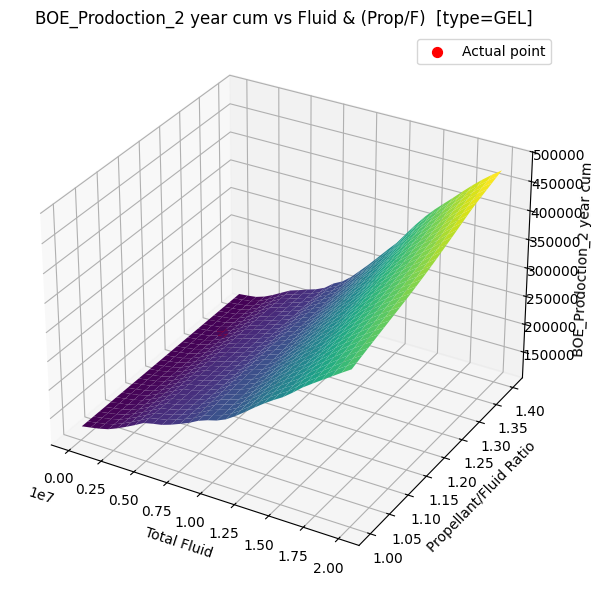

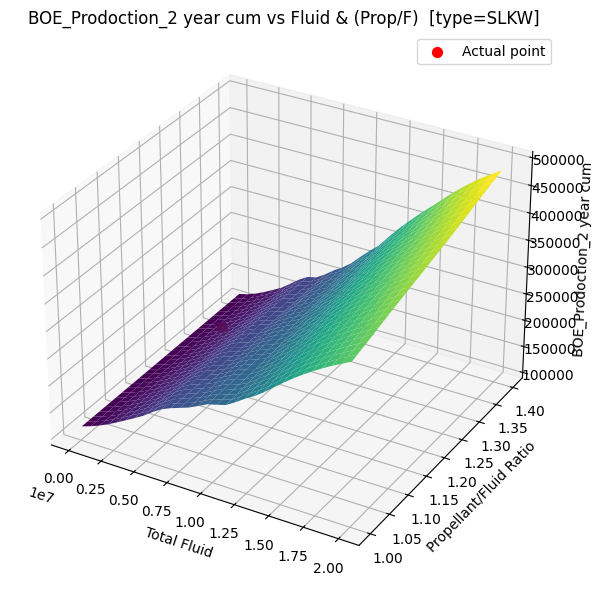

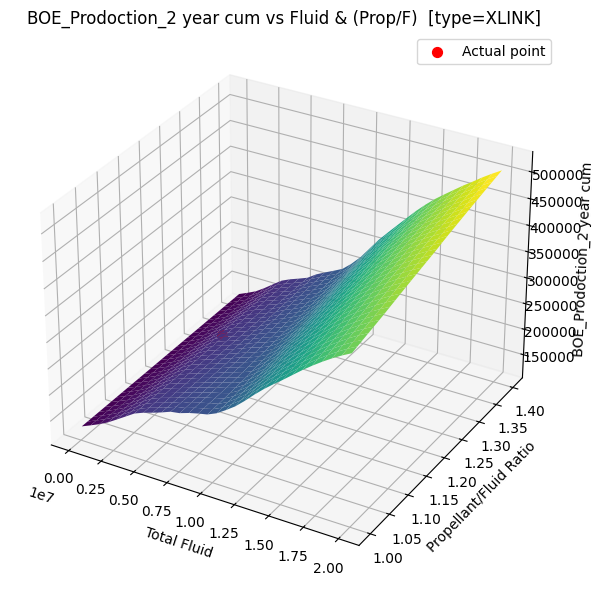

In [5]:

# ─── Example usage ─────────────────────────────────────────────────────────
plot_3d_response_pf_ratio_surface(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/5044f3a3",
    fold=6,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    fluid_range=(1e5, 2e7),
    pf_ratio_range=(1, 1.4),
    n_fluid=30,
    n_ratio=30
)

# redundatn removed softplus

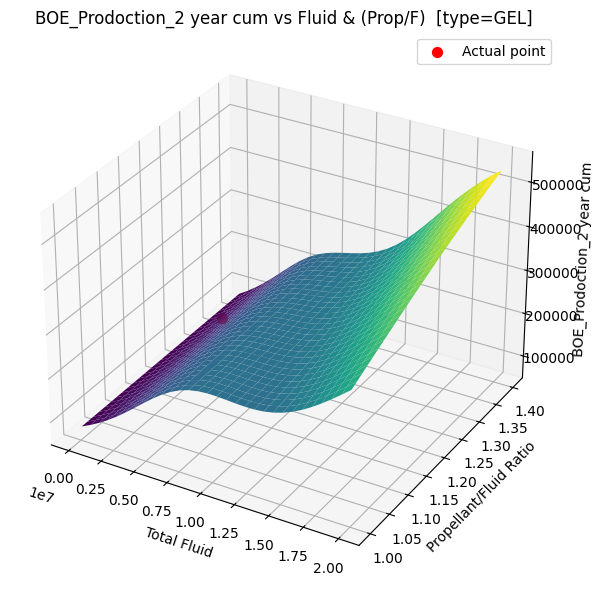

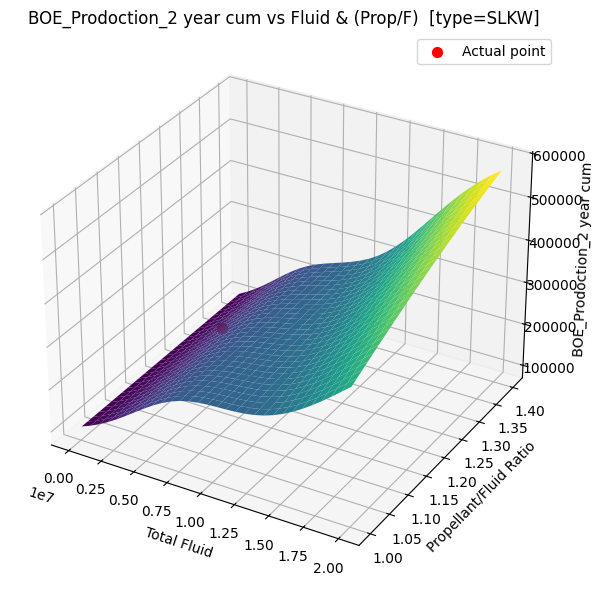

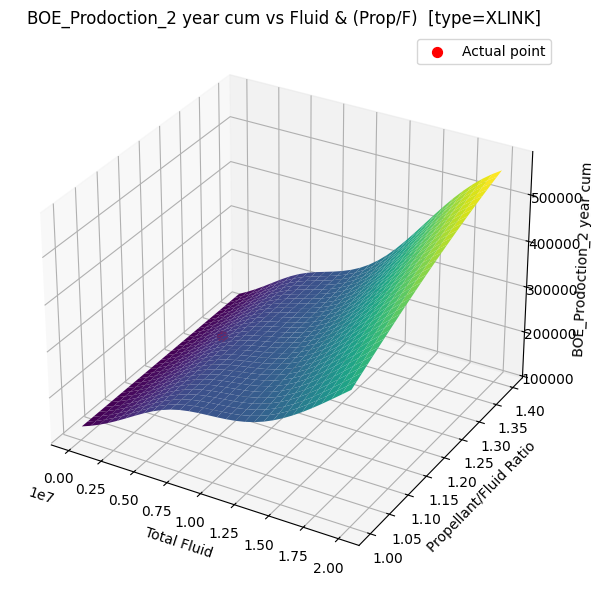

In [6]:

# ─── Example usage ─────────────────────────────────────────────────────────
plot_3d_response_pf_ratio_surface(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/98a1fcb5",
    fold=6,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    fluid_range=(1e5, 2e7),
    pf_ratio_range=(1, 1.4),
    n_fluid=30,
    n_ratio=30
)